<a href="https://colab.research.google.com/github/Ehsantba/Machine-Learning/blob/main/Biomedical_Signal_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Biomedical Signal Analysis
```
  __  __ _        _____           _           _   
 |  \/  | |      |  __ \         (_)         | |  
 | \  / | |      | |__) | __ ___  _  ___  ___| |_
 | |\/| | |      |  ___/ '__/ _ \| |/ _ \/ __| __|
 | |  | | |____  | |   | | | (_) | |  __/ (__| |_
 |_|  |_|______| |_|   |_|  \___/| |\___|\___|\__|
                                _/ |              
                               |__/               
```

In [ ]:
!pip install -qq wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 100.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.


In [ ]:
import os
import wfdb
import zipfile
import requests
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
# Add other required imports here

#### Download the EMG data

In [ ]:
url = "https://physionet.org/content/emgdb/get-zip/1.0.0/"
zip_file = "emgdb.zip"
if not os.path.exists(zip_file):
    response = requests.get(url)
    with open(zip_file, "wb") as f:
        f.write(response.content)

In [ ]:
extract_path = "emgdb"
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        zip_ref.extractall(extract_path)

## Signal Processing

In [ ]:
def bandpass_filter(signal, lowcut=20, highcut=450, fs=1000, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

## Feature Extraction

In [ ]:
def extract_features(segment):
    return [
        np.mean(np.abs(segment)),         # MAV
        np.sqrt(np.mean(segment**2)),     # RMS
        np.var(segment),                  # Variance
        ((segment[:-1] * segment[1:]) < 0).sum()  # Zero crossings
    ]

## Load and Prepare the Data

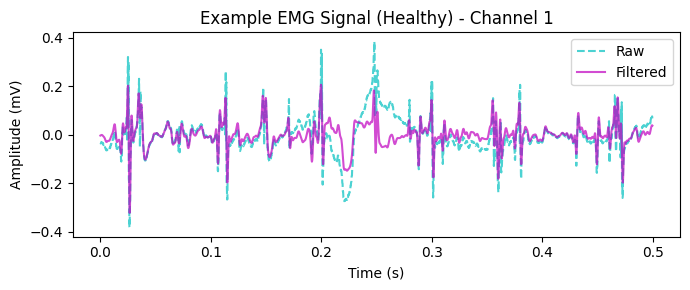

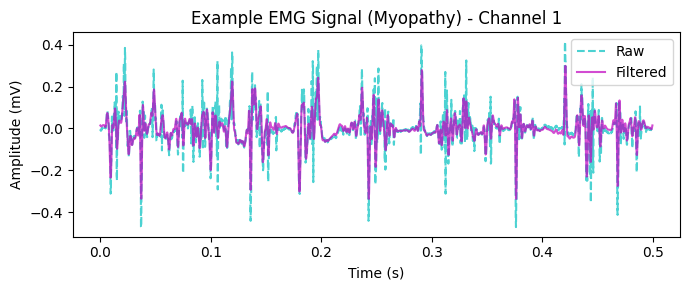

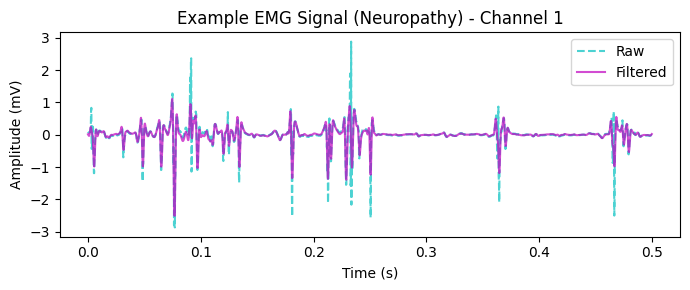

In [ ]:
classes = {
    "emg_healthy": 0,
    "emg_myopathy": 1,
    "emg_neuropathy": 2
}
class_names = ["Healthy", "Myopathy", "Neuropathy"]

X, y = [], []
window_size = int(0.2 * 1000)  # 200 ms
step_size = window_size // 2

for folder, label in classes.items():
    subject_path = os.path.join(
        extract_path, "examples-of-electromyograms-1.0.0", folder
    )
    record = wfdb.rdrecord(subject_path)
    signals = record.p_signal
    fs = record.fs

    # Filter all channels
    signals_filt = np.array([bandpass_filter(ch, fs=fs) for ch in signals.T]).T

    # --- Plot for inspection (first channel, first few seconds) ---
    t = np.arange(len(signals)) / fs
    plt.figure(figsize=(7, 3))
    plt.plot(t[:2000], signals[:2000, 0], 'c--', label="Raw", alpha=0.7)
    plt.plot(t[:2000], signals_filt[:2000, 0], 'm', label="Filtered", alpha=0.7)
    plt.title(f"Example EMG Signal ({class_names[label]}) - Channel 1")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (mV)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Extract features for classification
    for start in range(0, signals_filt.shape[0] - window_size, step_size):
        window = signals_filt[start:start+window_size, :]
        features = []
        for ch in range(window.shape[1]):
            features.extend(extract_features(window[:, ch]))
        X.append(features)
        y.append(label)

X = np.array(X)
y = np.array(y)

## Classification

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix , ConfusionMatrixDisplay


### 1. Data Preparation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
X_train.shape, X_test.shape

((2468, 4), (618, 4))

In [ ]:
print(X_train[:5])

[[1.08742219e-01 1.95005470e-01 3.79422090e-02 1.00000000e+01]
 [8.63229839e-02 2.19039391e-01 4.79472960e-02 1.30000000e+01]
 [4.38802154e-02 6.41250838e-02 4.11006796e-03 1.70000000e+01]
 [3.14085965e-02 4.40389979e-02 1.93504790e-03 1.30000000e+01]
 [5.52493491e-02 8.31407671e-02 6.91193801e-03 1.70000000e+01]]


### 2. Design and Train the Pipeline

In [ ]:
model_pipeline = Pipeline([('scaler', StandardScaler()),
 ('classifier', RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1))])

In [ ]:
model_pipeline.fit(X_train, y_train)


### 3. Evaluation

In [ ]:
y_pred = model_pipeline.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))
print("-" * 40)


In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=class_names, cmap='Blues', ax=ax)
plt.title('Confusion Matrix', fontsize=14)
plt.show()
print("-" * 40)


##Keras

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of y_train_one_hot:", y_train_one_hot.shape)

In [ ]:
model = Sequential([    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
Dropout(0.2),
Dense(3, activation='softmax')])
model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_scaled, y_train_one_hot,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test_scaled, y_test_one_hot),
                    verbose=1)

loss, accuracy = model.evaluate(X_test_scaled, y_test_one_hot, verbose=0)
y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)


ConfusionMatrixDisplay.from_predictions(y_test, y_pred_classes, display_labels=class_names, cmap='Blues')
plt.show()